# TEST ON TEST SET

In [17]:
from ift6758.data.nhl_data_parser import NHLDataParser
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score,RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
import wandb
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load the data
data_parser = NHLDataParser()
test_df = data_parser.get_shot_and_goal_pbp_df_for_season(2020, with_playoff_season=False)

In [3]:
#Data Preprocessing
def preprocess_data(train_df,scaling = False):
    dropped_columns = ['gameId',
                   'timeRemaining',
                   'periodNumber',
                   'timeInPeriod',
                   'xCoord',
                   'yCoord',
                   'zoneCode',
                   'shootingTeam',
                   'shootingPlayer',
                   'previousEventX',
                   'previousEventY',
                   'goalieInNet',
                   'shootingTeamSide',
                   ]
    numeric_columns = ['shotDistance',
                       'shotAngle',
                       'timeDiff',
                       'distanceDiff',
                       'shotAngleDiff',
                       'speed']
    train_df_clean = train_df.drop(columns=dropped_columns)

    #Drop rows with missing values
    train_df_clean = train_df_clean.dropna()
    
    #scale the numerical columns
    if scaling:
        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()
        train_df_clean[numeric_columns] = scaler.fit_transform(train_df_clean[numeric_columns])
    
   

    #one hot encoding
    train_df_clean = pd.get_dummies(train_df_clean,columns = ['shotType','previousEvent'])

    
    
    return train_df_clean






In [4]:
#default values
project_name = "IFT6758.2024-B08"
entity_name = "team08"
dir_path = os.getenv('WANDB_DIR')


In [ ]:

model_list = ['Decision_Tree:latest',
              'Linear_SVC:latest',
              'Kernel_SVC:latest',
              'Logistic_Regression:latest',
              'Random_Forest:latest',
              'lg_distance:latest',
              'lg_angle:latest',
              'lg_angle_distance:latest',
              'xgb_Final:latest']


# Initialize wandb
wandb.init(project=project_name, entity=entity_name, dir=dir_path)

# Download the model from wandb
for name in model_list:
    model_artifact = wandb.use_artifact(name)
    model_dir = model_artifact.download()
    model_file_name = os.path.basename(model_dir)
wandb.finish()





In [6]:
#load the models
import joblib
d_tree = joblib.load('artifacts\\Decision_Tree-v0\\decision_tree_undersample_newfeatures.pkl')
linear_svc = joblib.load('artifacts\\Linear_SVC-v0\\linearSvc_balanced_Kfold_newfeatures.pkl')
kernel_svc = joblib.load('artifacts\\Kernel_SVC-v0\\svc_balanced_Kfold_newfeatures.pkl')
lg_best = joblib.load('artifacts\\Logistic_Regression-v0\\logistic_newfeatures.pkl')
random_forest = joblib.load('artifacts\\Random_Forest-v0\\random_forest_balanced_newfeatures.pkl')
lg_distance = joblib.load('artifacts\\lg_distance-v0\\lg_distance.pkl')
lg_angle = joblib.load('artifacts\\lg_angle-v0\\lg_angle.pkl')
lg_angle_distance = joblib.load('artifacts\\lg_angle_distance-v0\\lg_distance_angle.pkl')
xgb = joblib.load('artifacts\\xgb_Final-v0\\xgb_final.pkl')


#make a dictionary of models
models = {'Random Forest':random_forest,
          'Logistic Regression Distance':lg_distance,
          'Logistic Regression Angle':lg_angle,
          'Logistic Regression Angle Distance':lg_angle_distance,
          'XGBoost':xgb}


## Best Model

In [7]:
test_df_clean = preprocess_data(test_df)
X_test = test_df_clean.drop(columns=['isGoal'])
y_test_rf = test_df_clean['isGoal']
prob_scores_rf = random_forest.predict_proba(X_test)[:,1]


# Logistic Regression : Angle

In [8]:
X_test = test_df[['shotAngle']]
y_test_lg_angle = test_df['isGoal']
prob_scores_lg_angle = lg_angle.predict_proba(X_test)[:,1]

# Logistic Regression : Distance

In [9]:
X_test = test_df[['shotDistance']]
y_test_lg_distance = test_df['isGoal']
prob_scores_lg_distance = lg_distance.predict_proba(X_test)[:,1]

# Logistic Regression : Angle and Distance

In [10]:
X_test = test_df[['shotDistance','shotAngle']]
y_test_angle_distance = test_df['isGoal']
prob_scores_lg_angle_distance = lg_angle_distance.predict_proba(X_test)[:,1]

# XgBoost

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
X_test = test_df[['periodNumber',
                   'shotAngle', 
                   'shotDistance', 
                   'shotType', 
                   'xCoord',
                   'yCoord', 
                   'previousEventX', 
                   'previousEventY', 
                   'rebound', 
                   'timeDiff',
                   'distanceDiff', 
                   'shotAngleDiff', 
                   'speed']]
X_test['shotType'] = encoder.fit_transform(X_test['shotType'])
y_test_xgboost = test_df['isGoal']

prob_scores_xgb = xgb.predict_proba(X_test)[:,1]


C:\Users\gogig\AppData\Local\Temp\ipykernel_21252\492228206.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['shotType'] = encoder.fit_transform(X_test['shotType'])


# Graphs

In [12]:
# Collect probabilities from all models as tuples :(name,scores,y_test)
model_probabilities = [('Random Forest',prob_scores_rf,y_test_rf),
                       ('Logistic Regression: Distance',prob_scores_lg_distance,y_test_lg_distance),
                       ('Logistic Regression: Angle',prob_scores_lg_angle,y_test_lg_angle),
                       ('Logistic Regression: Angle,Distance',prob_scores_lg_angle_distance,y_test_angle_distance),
                       ('XGBoost',prob_scores_xgb,y_test_xgboost)]



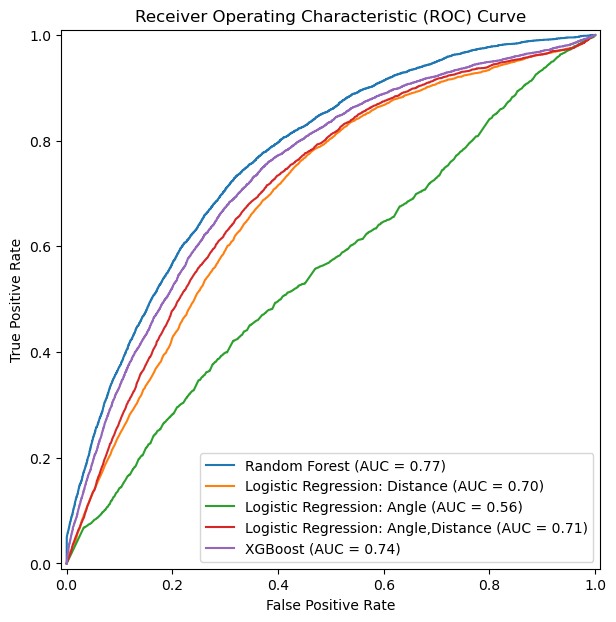

In [16]:
##Graph 1: Roc Curve

fig_1, ax_1 = plt.subplots()
roc = {}
plot_random = False #This is just to make sure that the random classifier is only plotted once

#Plot the ROC curve for each classifier
for name , prob_score , y_test in model_probabilities:
    if name == 'Angle and Distance': #Only plot the random classifier once at the end
        plot_random = True  
    roc[name] = RocCurveDisplay.from_predictions(y_test, prob_score , plot_chance_level=plot_random, ax=ax_1,name=name)
ax_1.set_title('Receiver Operating Characteristic (ROC) Curve')
ax_1.set_xlabel('False Positive Rate')
ax_1.set_ylabel('True Positive Rate')
fig_1.set_size_inches(7,7)
fig_1.savefig('roc_curve_task7.png')


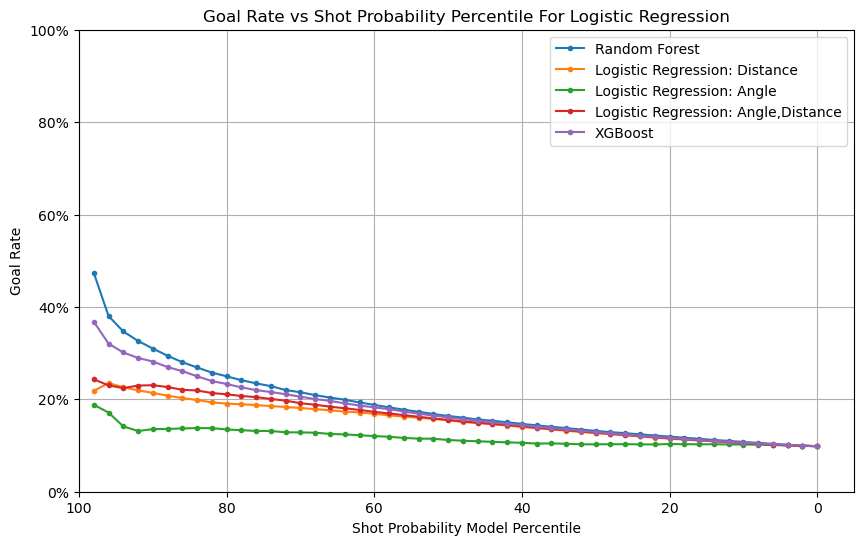

In [19]:
#Graph 2: Goal Rate as a Function of Shot Probability Model Percentile

# Calculate the percentiles for the shot probabilities for all models
percentile_bins = np.arange(0, 100, 2)
percentiles = {}
for name, prob_score,_ in model_probabilities:
    percentile_data = np.percentile(prob_score , percentile_bins)
    percentiles[name] = percentile_data


# Calculate the goal rates for each percentile for all models
goal_rates = {}
for name, prob_score,y_test in model_probabilities:
    goal_rates[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        goal_rates[name].append(y_test[mask].mean())


# Plot the goal rate as a function of the shot probability model percentile for all models

fig_2, ax_2 = plt.subplots()
for name, goal_rate in goal_rates.items():
    ax_2.plot(percentile_bins, goal_rate, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Goal Rate')
plt.title('Goal Rate vs Shot Probability Percentile For Logistic Regression')
plt.grid(True)
plt.legend()
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, -5)
fig_2.set_size_inches(10,6)
plt.show()
fig_2.savefig('goal_rate_task7.png')


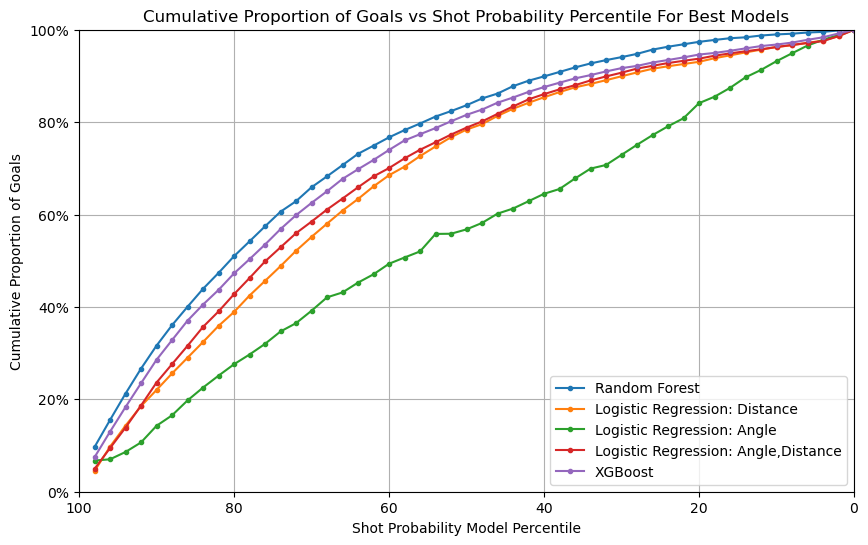

In [21]:
# Graph 3: Cumulative Proportion of Goals as a Function of Shot Probability Model Percentile 

# Calculate the cumulative goal percentage for each percentile for all models
cumulative_goal_proportions = {}
for name, prob_score, y_test in model_probabilities:
    cumulative_goal_proportions[name] = []
    for percentile in percentiles[name]:
        mask = prob_score  >= percentile
        cumulative_goal_proportions[name].append(y_test[mask].sum() / y_test.sum())


# Plot the cumulative proportion of goals as a function of the shot probability model percentile for all models
fig_3, ax_3 = plt.subplots()
for name, cumulative_goal_proportion in cumulative_goal_proportions.items():
    ax_3.plot(percentile_bins, cumulative_goal_proportion, marker='.', label=name)
plt.xlabel('Shot Probability Model Percentile')
plt.ylabel('Cumulative Proportion of Goals')
plt.title('Cumulative Proportion of Goals vs Shot Probability Percentile For Best Models')
plt.grid(True)
plt.ylim(0, 1)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.xlim(100, 0)
plt.legend()
fig_3.set_size_inches(10,6)
plt.show()
fig_3.savefig('cumulative_goal_proportion_task7.png')


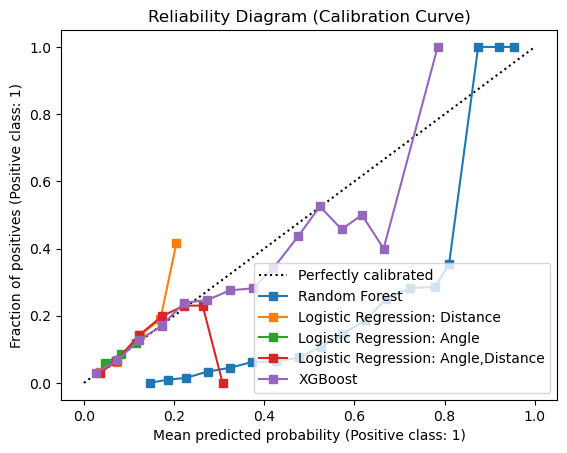

In [24]:
# Graph 4: Calibration Curve
fig_4,ax_4 = plt.subplots()
#Plot the calibration curve for each classifier
for name, prob_score, y_test in model_probabilities:
    CalibrationDisplay.from_predictions(y_test, prob_score, n_bins=20, strategy='uniform',ax=ax_4,name=name)
plt.title('Reliability Diagram (Calibration Curve)')
plt.show()
fig_4.savefig('calibration_curve_task7.png')